<a href="https://colab.research.google.com/github/asdfasdf001234/2024-1-MLPRJ/blob/main/ConvNeXt_test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [45]:
import os
import time
import shutil
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.optim import lr_scheduler
import seaborn as sns
from torchvision import models
# Load training data
from torch.utils.data import Dataset , DataLoader
from torchvision import datasets
from torchvision.transforms import v2
from torch.utils.data import random_split
from PIL import Image
from glob import glob
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [30]:
data_path = "drive/MyDrive/img_model_test"

In [60]:
import random

def set_random_seed(seed_value):
    torch.manual_seed(seed_value)
    torch.cuda.manual_seed_all(seed_value)
    np.random.seed(seed_value)
    random.seed(seed_value)

# Set a random seed value
seed_value = 42
set_random_seed(seed_value)


In [39]:
def create_dataframe(data_path, label_list, data_type):
    df = pd.DataFrame({"path": [], "label": [], "class_id": []})
    img_list = glob(os.path.join(data_path, '*.jpg'))

    for img in img_list:
      file_name = os.path.splitext(os.path.basename(img))[0]
      label_index = int(file_name[0]) - 1  #진영님 코드와 동일
      if 0 <= label_index < len(label_list):
        label = label_list[label_index]
        new_data = pd.DataFrame({"path": [img], "label": [label], "class_id": [label_index]})
        df = pd.concat([df, new_data], ignore_index=True)

    df[["path"]] = df[["path"]].astype(str)
    df[["label"]] = df[["label"]].astype(str)
    df[["class_id"]] = df[["class_id"]].astype(int)

    return df

In [40]:
train_path = data_path + '/train/train/'
valid_path = data_path + '/val/val/'
test_path = data_path + '/test/test/'
label_list = ['spring', 'summer', 'autumn', 'winter']

train_df = create_dataframe(train_path, label_list, 'training')
val_df = create_dataframe(valid_path, label_list, 'validation')
test_df = create_dataframe(test_path, label_list, 'test')

In [41]:
print(f"train_data: {len(train_df)}")
print(f"val_data:{len(val_df)}")
print(f"test_data:{len(test_df)}")

train_data: 40
val_data:20
test_data:20


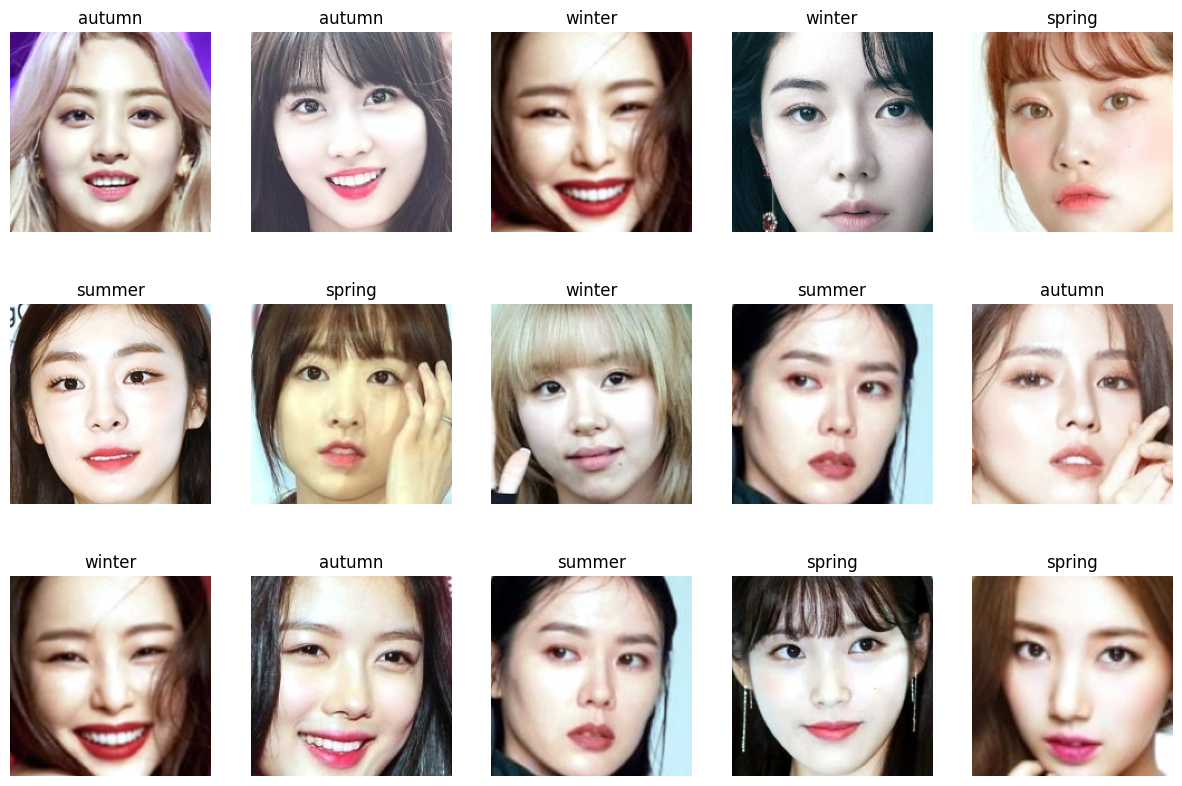

In [42]:
show_imgs = 15
idx = np.random.randint(0,len(val_df) , size = show_imgs)
fig , axes = plt.subplots(show_imgs // 5 , 5 , figsize = (15 , 10))
axes = axes.flatten()
for i , ax in enumerate(axes):
    full_path = val_df.loc[idx[i]]['path']
    ax.imshow(plt.imread(full_path))
    ax.set_title(val_df.loc[idx[i]]['label'])
    ax.set_axis_off()

In [43]:
class BaseDataset(torch.utils.data.Dataset):
    def __init__(self , dataframe , transforms_):
        self.df = dataframe
        self.transforms_ = transforms_

    def __len__(self):
        return len(self.df)

    def __getitem__(self ,index):
        img_path = self.df.iloc[index]['path']
        img = Image.open(img_path).convert("RGB")
        transformed_img = self.transforms_(img)
        class_id = self.df.iloc[index]['class_id']
        return transformed_img , class_id

In [61]:
Transforms = v2.Compose([
    #===============================#
    v2.Resize((224,224)),
    #v2.RandomResizedCrop(size=(224,224), antialias=True), # image 크기 맞추기
    v2.PILToTensor(), # torch.tensor로 변환
    v2.ToDtype(torch.float32),
    v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    v2.RandomRotation(50),
    v2.RandomHorizontalFlip(p=0.5),
    #v2.ColorJitter(),
    #===============================#
    ]) # dtype 변환

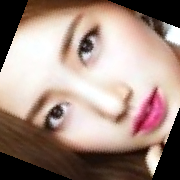

In [62]:
# augmentation 참고
# https://pytorch.org/vision/main/transforms.html

rotation_transform = v2.RandomRotation(degrees=90) # compose에 추가 가능
image = Image.open(full_path)
rotated_image = rotation_transform(image)
rotated_image


In [115]:
#get dataloader
BATCH_SIZE = 5
train_dataset = BaseDataset(train_df , Transforms) # train_transforms
val_dataset = BaseDataset(val_df , Transforms)
test_dataset = BaseDataset(test_df , Transforms)
train_loader = DataLoader(train_dataset , batch_size=BATCH_SIZE , shuffle = True)
val_loader = DataLoader(val_dataset , batch_size=BATCH_SIZE)
test_loader = DataLoader(test_dataset , batch_size=BATCH_SIZE)

In [116]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [117]:
convnext = models.convnext_base(weights=models.ConvNeXt_Base_Weights.DEFAULT)

In [66]:
print(convnext)

ConvNeXt(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 128, kernel_size=(4, 4), stride=(4, 4))
      (1): LayerNorm2d((128,), eps=1e-06, elementwise_affine=True)
    )
    (1): Sequential(
      (0): CNBlock(
        (block): Sequential(
          (0): Conv2d(128, 128, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=128)
          (1): Permute()
          (2): LayerNorm((128,), eps=1e-06, elementwise_affine=True)
          (3): Linear(in_features=128, out_features=512, bias=True)
          (4): GELU(approximate='none')
          (5): Linear(in_features=512, out_features=128, bias=True)
          (6): Permute()
        )
        (stochastic_depth): StochasticDepth(p=0.0, mode=row)
      )
      (1): CNBlock(
        (block): Sequential(
          (0): Conv2d(128, 128, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=128)
          (1): Permute()
          (2): LayerNorm((128,), eps=1e-06, elementwise_affine=True)
          (3): Linear(

In [118]:
class MyConvNeXt(nn.Module):
    def __init__(self, pretrained_model):
        super(MyConvNeXt, self).__init__()
        #self.backbone = nn.Sequential(*list(pretrained_model.children())[:-2])
        self.backbone = pretrained_model

        for param in self.backbone.parameters():
            param.requires_grad = False

        self.fc1 = nn.Linear(1000, 1000)
        self.fc2 = nn.Linear(1000, 500)
        self.fc3 = nn.Linear(500, 4)

        self.dropout = nn.Dropout(0.5)
        self.flatten = nn.Flatten()

    def forward(self, x):
        x = self.backbone(x)
        #x = x.view(x.size(0), -1) # flatten
        x = self.dropout(x)
        #x = self.flatten(x)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.fc3(x)
        return x


In [119]:
myconvnext = MyConvNeXt(convnext)

In [120]:
def train(dataloader , model , loss_fn , optimizer , lr_scheduler):
    size = 0
    num_batches = len(dataloader)

    model.train()
    epoch_loss , epoch_correct = 0 , 0

    for i ,(data_ , target_) in enumerate(dataloader):

        size += data_.size(0)

        # GPU에 올리기
        data, target = data_.to(device), target_.to(device)
        #target = target.unsqueeze(1).float()

        # prediction, loss 계산
        pred = model(data)
        _, pred_max = torch.max(pred, 1)

        loss = loss_fn(pred, target)

        # backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()
        epoch_correct += (pred_max == target).type(torch.float).sum().item()

    train_acc = epoch_correct / size
    lr_scheduler.step()

    return train_acc , epoch_loss / num_batches


def test(dataloader , model , loss_fn):
    size = 0
    num_baches = len(dataloader)
    epoch_loss , epoch_correct= 0 ,0

    with torch.no_grad(): # grad 연산 X
        model.eval() # evaluation dropout 연산시

        for i, (data_ , target_) in enumerate(dataloader):

            size += data_.size(0)

            # GPU에 올리기
            data, target = data_.to(device), target_.to(device)
            #target = target.unsqueeze(1).float()

            # prediction, loss 계산
            pred = model(data)
            _, pred_max = torch.max(pred, 1)

            loss = loss_fn(pred, target)

            epoch_loss += loss.item()
            epoch_correct += (pred_max == target).type(torch.float).sum().item()

    test_acc = epoch_correct / size

    return test_acc  , epoch_loss / num_baches

In [121]:
myconvnext.cuda()

MyConvNeXt(
  (backbone): ConvNeXt(
    (features): Sequential(
      (0): Conv2dNormActivation(
        (0): Conv2d(3, 128, kernel_size=(4, 4), stride=(4, 4))
        (1): LayerNorm2d((128,), eps=1e-06, elementwise_affine=True)
      )
      (1): Sequential(
        (0): CNBlock(
          (block): Sequential(
            (0): Conv2d(128, 128, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=128)
            (1): Permute()
            (2): LayerNorm((128,), eps=1e-06, elementwise_affine=True)
            (3): Linear(in_features=128, out_features=512, bias=True)
            (4): GELU(approximate='none')
            (5): Linear(in_features=512, out_features=128, bias=True)
            (6): Permute()
          )
          (stochastic_depth): StochasticDepth(p=0.0, mode=row)
        )
        (1): CNBlock(
          (block): Sequential(
            (0): Conv2d(128, 128, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=128)
            (1): Permute()
            (2): Laye

In [122]:
seed_value = 42
set_random_seed(seed_value)

EPOCHS = 100
logs = {"train_loss":[] , "train_acc":[] , "val_loss":[] , "val_acc":[]}

if os.path.exists('checkpoints') == False:
    os.mkdir('checkpoints')

criterion = nn.CrossEntropyLoss()

optimizer = optim.Adam(myconvnext.parameters(), lr=1e-5)
Cosine_lr_scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=100)

patience = 10
counter = 0
best_loss = np.inf

In [123]:
for epoch in tqdm(range(EPOCHS)):
    train_acc, train_loss = train(train_loader,
                                  myconvnext,
                                  criterion,
                                  optimizer,
                                  Cosine_lr_scheduler)

    val_acc, val_loss = test(val_loader, myconvnext, criterion)
    print(f'epoch:{epoch} \
    train_loss = {train_loss:.4f}, train_acc:{train_acc:.4f} \
    val_loss = {val_loss:.4f}, val_acc:{val_acc:.4f} \
    learning rate: {optimizer.param_groups[0]["lr"]}')
    logs['train_loss'].append(train_loss)
    logs['train_acc'].append(train_acc)
    logs['val_loss'].append(val_loss)
    logs['val_acc'].append(val_acc)

    if val_loss < best_loss:
        counter = 0
        best_loss = val_loss
        torch.save(myconvnext.state_dict(), "checkpoints/myconvnext_best.pth")
    else:
        counter += 1

    #if counter >= patience:
        #print("Early stop!")
        #break

test_acc, test_loss = test(test_loader, myconvnext, criterion)
print(test_acc)


  0%|          | 0/100 [00:00<?, ?it/s]

epoch:0     train_loss = 1.4584, train_acc:0.1500     val_loss = 1.4001, val_acc:0.2000     learning rate: 9.997532801828659e-06


  1%|          | 1/100 [00:01<02:25,  1.47s/it]

epoch:1     train_loss = 1.3718, train_acc:0.3250     val_loss = 1.3989, val_acc:0.2000     learning rate: 9.990133642141359e-06


  2%|▏         | 2/100 [00:03<03:14,  1.98s/it]

epoch:2     train_loss = 1.3560, train_acc:0.3250     val_loss = 1.3901, val_acc:0.2000     learning rate: 9.977809823015402e-06


  4%|▍         | 4/100 [00:07<03:02,  1.90s/it]

epoch:3     train_loss = 1.3750, train_acc:0.2750     val_loss = 1.4000, val_acc:0.2000     learning rate: 9.960573506572391e-06
epoch:4     train_loss = 1.4354, train_acc:0.2000     val_loss = 1.3836, val_acc:0.2000     learning rate: 9.93844170297569e-06


  6%|▌         | 6/100 [00:10<02:36,  1.66s/it]

epoch:5     train_loss = 1.4512, train_acc:0.2000     val_loss = 1.3963, val_acc:0.3000     learning rate: 9.911436253643447e-06


  7%|▋         | 7/100 [00:11<02:02,  1.32s/it]

epoch:6     train_loss = 1.4214, train_acc:0.2500     val_loss = 1.3993, val_acc:0.2000     learning rate: 9.87958380969374e-06


  8%|▊         | 8/100 [00:11<01:39,  1.08s/it]

epoch:7     train_loss = 1.3899, train_acc:0.3750     val_loss = 1.3925, val_acc:0.2000     learning rate: 9.842915805643158e-06


  9%|▉         | 9/100 [00:12<01:23,  1.09it/s]

epoch:8     train_loss = 1.4096, train_acc:0.3000     val_loss = 1.3945, val_acc:0.2500     learning rate: 9.801468428384718e-06


 10%|█         | 10/100 [00:12<01:12,  1.24it/s]

epoch:9     train_loss = 1.4321, train_acc:0.2250     val_loss = 1.4021, val_acc:0.1500     learning rate: 9.75528258147577e-06


 11%|█         | 11/100 [00:13<01:04,  1.39it/s]

epoch:10     train_loss = 1.4197, train_acc:0.3000     val_loss = 1.3908, val_acc:0.3000     learning rate: 9.70440384477113e-06


 12%|█▏        | 12/100 [00:14<00:59,  1.49it/s]

epoch:11     train_loss = 1.3490, train_acc:0.3500     val_loss = 1.4021, val_acc:0.1500     learning rate: 9.64888242944126e-06


 13%|█▎        | 13/100 [00:14<00:54,  1.59it/s]

epoch:12     train_loss = 1.4031, train_acc:0.2500     val_loss = 1.3913, val_acc:0.2000     learning rate: 9.588773128419908e-06


 14%|█▍        | 14/100 [00:15<00:52,  1.65it/s]

epoch:13     train_loss = 1.4084, train_acc:0.3250     val_loss = 1.3888, val_acc:0.2500     learning rate: 9.524135262330102e-06


 15%|█▌        | 15/100 [00:15<00:50,  1.68it/s]

epoch:14     train_loss = 1.4004, train_acc:0.2750     val_loss = 1.3903, val_acc:0.3000     learning rate: 9.455032620941843e-06


 16%|█▌        | 16/100 [00:16<00:49,  1.71it/s]

epoch:15     train_loss = 1.3972, train_acc:0.3250     val_loss = 1.3933, val_acc:0.3000     learning rate: 9.381533400219322e-06


 17%|█▋        | 17/100 [00:16<00:48,  1.72it/s]

epoch:16     train_loss = 1.3614, train_acc:0.3500     val_loss = 1.3916, val_acc:0.3000     learning rate: 9.303710135019723e-06


 18%|█▊        | 18/100 [00:17<00:46,  1.77it/s]

epoch:17     train_loss = 1.4204, train_acc:0.2750     val_loss = 1.3884, val_acc:0.2500     learning rate: 9.22163962751008e-06


 19%|█▉        | 19/100 [00:17<00:45,  1.80it/s]

epoch:18     train_loss = 1.3994, train_acc:0.2500     val_loss = 1.3985, val_acc:0.3000     learning rate: 9.135402871372813e-06


 20%|██        | 20/100 [00:18<00:44,  1.80it/s]

epoch:19     train_loss = 1.3682, train_acc:0.3000     val_loss = 1.3862, val_acc:0.3000     learning rate: 9.045084971874742e-06


 21%|██        | 21/100 [00:18<00:43,  1.82it/s]

epoch:20     train_loss = 1.4675, train_acc:0.1250     val_loss = 1.3973, val_acc:0.2500     learning rate: 8.950775061878454e-06


 22%|██▏       | 22/100 [00:19<00:42,  1.83it/s]

epoch:21     train_loss = 1.3701, train_acc:0.3000     val_loss = 1.3856, val_acc:0.3000     learning rate: 8.852566213878949e-06


 23%|██▎       | 23/100 [00:20<00:42,  1.81it/s]

epoch:22     train_loss = 1.3938, train_acc:0.2750     val_loss = 1.3889, val_acc:0.3500     learning rate: 8.7505553481523e-06


 24%|██▍       | 24/100 [00:20<00:41,  1.81it/s]

epoch:23     train_loss = 1.4490, train_acc:0.1000     val_loss = 1.3967, val_acc:0.2000     learning rate: 8.644843137107061e-06


 25%|██▌       | 25/100 [00:21<00:42,  1.77it/s]

epoch:24     train_loss = 1.4368, train_acc:0.2000     val_loss = 1.3851, val_acc:0.3000     learning rate: 8.53553390593274e-06


 26%|██▌       | 26/100 [00:21<00:42,  1.74it/s]

epoch:25     train_loss = 1.4090, train_acc:0.2500     val_loss = 1.3892, val_acc:0.1000     learning rate: 8.422735529643446e-06


 27%|██▋       | 27/100 [00:22<00:41,  1.76it/s]

epoch:26     train_loss = 1.4078, train_acc:0.2250     val_loss = 1.3913, val_acc:0.2000     learning rate: 8.306559326618261e-06


 28%|██▊       | 28/100 [00:22<00:41,  1.73it/s]

epoch:27     train_loss = 1.3991, train_acc:0.2750     val_loss = 1.3917, val_acc:0.2500     learning rate: 8.187119948743451e-06


 29%|██▉       | 29/100 [00:23<00:41,  1.73it/s]

epoch:28     train_loss = 1.4335, train_acc:0.2000     val_loss = 1.3987, val_acc:0.1000     learning rate: 8.064535268264885e-06


 30%|███       | 30/100 [00:24<00:40,  1.72it/s]

epoch:29     train_loss = 1.4160, train_acc:0.2000     val_loss = 1.3896, val_acc:0.2000     learning rate: 7.938926261462368e-06


 31%|███       | 31/100 [00:24<00:40,  1.72it/s]

epoch:30     train_loss = 1.3988, train_acc:0.1750     val_loss = 1.3849, val_acc:0.4000     learning rate: 7.810416889260654e-06


 32%|███▏      | 32/100 [00:25<00:39,  1.73it/s]

epoch:31     train_loss = 1.4145, train_acc:0.3250     val_loss = 1.3880, val_acc:0.3500     learning rate: 7.679133974894984e-06


 33%|███▎      | 33/100 [00:25<00:38,  1.74it/s]

epoch:32     train_loss = 1.4093, train_acc:0.2500     val_loss = 1.3841, val_acc:0.2500     learning rate: 7.545207078751858e-06


 34%|███▍      | 34/100 [00:26<00:37,  1.74it/s]

epoch:33     train_loss = 1.3849, train_acc:0.2750     val_loss = 1.4021, val_acc:0.2000     learning rate: 7.408768370508578e-06


 35%|███▌      | 35/100 [00:26<00:37,  1.73it/s]

epoch:34     train_loss = 1.4867, train_acc:0.1750     val_loss = 1.3841, val_acc:0.2000     learning rate: 7.269952498697735e-06


 36%|███▌      | 36/100 [00:27<00:37,  1.72it/s]

epoch:35     train_loss = 1.3787, train_acc:0.2750     val_loss = 1.3959, val_acc:0.3500     learning rate: 7.128896457825365e-06


 37%|███▋      | 37/100 [00:28<00:36,  1.72it/s]

epoch:36     train_loss = 1.4241, train_acc:0.1250     val_loss = 1.3845, val_acc:0.3000     learning rate: 6.985739453173904e-06


 38%|███▊      | 38/100 [00:28<00:35,  1.73it/s]

epoch:37     train_loss = 1.3973, train_acc:0.2500     val_loss = 1.3917, val_acc:0.2500     learning rate: 6.840622763423393e-06


 39%|███▉      | 39/100 [00:29<00:35,  1.73it/s]

epoch:38     train_loss = 1.4216, train_acc:0.2750     val_loss = 1.3941, val_acc:0.2500     learning rate: 6.693689601226459e-06


 40%|████      | 40/100 [00:29<00:34,  1.75it/s]

epoch:39     train_loss = 1.3905, train_acc:0.3000     val_loss = 1.3844, val_acc:0.3000     learning rate: 6.545084971874739e-06


 41%|████      | 41/100 [00:30<00:33,  1.75it/s]

epoch:40     train_loss = 1.5135, train_acc:0.0750     val_loss = 1.3884, val_acc:0.2500     learning rate: 6.394955530196148e-06


 42%|████▏     | 42/100 [00:31<00:33,  1.75it/s]

epoch:41     train_loss = 1.4230, train_acc:0.1750     val_loss = 1.3882, val_acc:0.1500     learning rate: 6.243449435824274e-06


 43%|████▎     | 43/100 [00:31<00:32,  1.75it/s]

epoch:42     train_loss = 1.3953, train_acc:0.2750     val_loss = 1.3964, val_acc:0.1500     learning rate: 6.090716206982715e-06


 44%|████▍     | 44/100 [00:32<00:32,  1.71it/s]

epoch:43     train_loss = 1.3760, train_acc:0.3500     val_loss = 1.3840, val_acc:0.2500     learning rate: 5.9369065729286255e-06


 45%|████▌     | 45/100 [00:32<00:32,  1.71it/s]

epoch:44     train_loss = 1.3718, train_acc:0.3000     val_loss = 1.3841, val_acc:0.3500     learning rate: 5.7821723252011565e-06


 46%|████▌     | 46/100 [00:33<00:32,  1.68it/s]

epoch:45     train_loss = 1.4132, train_acc:0.2750     val_loss = 1.3872, val_acc:0.3000     learning rate: 5.626666167821524e-06


 47%|████▋     | 47/100 [00:34<00:31,  1.67it/s]

epoch:46     train_loss = 1.3882, train_acc:0.3000     val_loss = 1.3946, val_acc:0.2500     learning rate: 5.470541566592573e-06


 48%|████▊     | 48/100 [00:34<00:30,  1.68it/s]

epoch:47     train_loss = 1.4375, train_acc:0.3000     val_loss = 1.3858, val_acc:0.3000     learning rate: 5.313952597646569e-06


 49%|████▉     | 49/100 [00:35<00:29,  1.71it/s]

epoch:48     train_loss = 1.3518, train_acc:0.3250     val_loss = 1.3877, val_acc:0.3000     learning rate: 5.1570537953906435e-06


 50%|█████     | 50/100 [00:35<00:29,  1.72it/s]

epoch:49     train_loss = 1.3664, train_acc:0.3250     val_loss = 1.3956, val_acc:0.3500     learning rate: 5.000000000000002e-06


 51%|█████     | 51/100 [00:36<00:28,  1.72it/s]

epoch:50     train_loss = 1.3690, train_acc:0.3750     val_loss = 1.3863, val_acc:0.2500     learning rate: 4.842946204609361e-06


 52%|█████▏    | 52/100 [00:36<00:27,  1.75it/s]

epoch:51     train_loss = 1.3316, train_acc:0.3000     val_loss = 1.3920, val_acc:0.3000     learning rate: 4.686047402353435e-06


 53%|█████▎    | 53/100 [00:37<00:26,  1.75it/s]

epoch:52     train_loss = 1.4097, train_acc:0.2750     val_loss = 1.3844, val_acc:0.2000     learning rate: 4.5294584334074295e-06


 54%|█████▍    | 54/100 [00:37<00:26,  1.75it/s]

epoch:53     train_loss = 1.4289, train_acc:0.2250     val_loss = 1.3986, val_acc:0.1500     learning rate: 4.37333383217848e-06


 55%|█████▌    | 55/100 [00:38<00:25,  1.77it/s]

epoch:54     train_loss = 1.3868, train_acc:0.3000     val_loss = 1.3952, val_acc:0.3500     learning rate: 4.217827674798846e-06


 56%|█████▌    | 56/100 [00:39<00:24,  1.81it/s]

epoch:55     train_loss = 1.4179, train_acc:0.3000     val_loss = 1.4024, val_acc:0.1500     learning rate: 4.063093427071377e-06


 57%|█████▋    | 57/100 [00:39<00:23,  1.81it/s]

epoch:56     train_loss = 1.4044, train_acc:0.2000     val_loss = 1.3989, val_acc:0.3000     learning rate: 3.909283793017289e-06


 58%|█████▊    | 58/100 [00:40<00:23,  1.78it/s]

epoch:57     train_loss = 1.3801, train_acc:0.2750     val_loss = 1.3975, val_acc:0.2500     learning rate: 3.756550564175726e-06


 59%|█████▉    | 59/100 [00:40<00:22,  1.80it/s]

epoch:58     train_loss = 1.3479, train_acc:0.2750     val_loss = 1.3961, val_acc:0.2500     learning rate: 3.6050444698038542e-06


 60%|██████    | 60/100 [00:41<00:22,  1.78it/s]

epoch:59     train_loss = 1.4114, train_acc:0.2750     val_loss = 1.3854, val_acc:0.3000     learning rate: 3.4549150281252644e-06


 61%|██████    | 61/100 [00:41<00:21,  1.80it/s]

epoch:60     train_loss = 1.3620, train_acc:0.3250     val_loss = 1.3926, val_acc:0.1500     learning rate: 3.3063103987735433e-06
epoch:61     train_loss = 1.3933, train_acc:0.2000     val_loss = 1.3823, val_acc:0.4000     learning rate: 3.159377236576612e-06


 63%|██████▎   | 63/100 [00:44<00:36,  1.00it/s]

epoch:62     train_loss = 1.3955, train_acc:0.2000     val_loss = 1.3950, val_acc:0.2000     learning rate: 3.0142605468260967e-06


 64%|██████▍   | 64/100 [00:45<00:31,  1.15it/s]

epoch:63     train_loss = 1.3895, train_acc:0.3250     val_loss = 1.3894, val_acc:0.3000     learning rate: 2.871103542174637e-06


 65%|██████▌   | 65/100 [00:45<00:27,  1.26it/s]

epoch:64     train_loss = 1.3656, train_acc:0.2250     val_loss = 1.3865, val_acc:0.3000     learning rate: 2.7300475013022666e-06


 66%|██████▌   | 66/100 [00:46<00:25,  1.35it/s]

epoch:65     train_loss = 1.4079, train_acc:0.2250     val_loss = 1.3898, val_acc:0.2500     learning rate: 2.5912316294914232e-06


 67%|██████▋   | 67/100 [00:47<00:22,  1.44it/s]

epoch:66     train_loss = 1.4330, train_acc:0.2500     val_loss = 1.3972, val_acc:0.2500     learning rate: 2.4547929212481436e-06


 68%|██████▊   | 68/100 [00:47<00:21,  1.49it/s]

epoch:67     train_loss = 1.3373, train_acc:0.4000     val_loss = 1.3850, val_acc:0.3500     learning rate: 2.320866025105016e-06


 69%|██████▉   | 69/100 [00:48<00:20,  1.55it/s]

epoch:68     train_loss = 1.3933, train_acc:0.1750     val_loss = 1.3978, val_acc:0.2500     learning rate: 2.189583110739347e-06
epoch:69     train_loss = 1.3928, train_acc:0.2500     val_loss = 1.3819, val_acc:0.4000     learning rate: 2.061073738537635e-06


 70%|███████   | 70/100 [00:49<00:26,  1.14it/s]

epoch:70     train_loss = 1.4216, train_acc:0.2750     val_loss = 1.3805, val_acc:0.2500     learning rate: 1.935464731735117e-06


 72%|███████▏  | 72/100 [00:52<00:28,  1.02s/it]

epoch:71     train_loss = 1.4313, train_acc:0.2750     val_loss = 1.3881, val_acc:0.3000     learning rate: 1.8128800512565512e-06


 73%|███████▎  | 73/100 [00:53<00:29,  1.09s/it]

epoch:72     train_loss = 1.3606, train_acc:0.3500     val_loss = 1.4021, val_acc:0.4000     learning rate: 1.6934406733817415e-06


 74%|███████▍  | 74/100 [00:54<00:24,  1.08it/s]

epoch:73     train_loss = 1.3797, train_acc:0.2500     val_loss = 1.4018, val_acc:0.2000     learning rate: 1.5772644703565564e-06


 75%|███████▌  | 75/100 [00:54<00:20,  1.22it/s]

epoch:74     train_loss = 1.4200, train_acc:0.2250     val_loss = 1.3884, val_acc:0.2000     learning rate: 1.4644660940672628e-06


 76%|███████▌  | 76/100 [00:55<00:17,  1.35it/s]

epoch:75     train_loss = 1.3803, train_acc:0.3000     val_loss = 1.3905, val_acc:0.2500     learning rate: 1.3551568628929434e-06


 77%|███████▋  | 77/100 [00:55<00:15,  1.45it/s]

epoch:76     train_loss = 1.3841, train_acc:0.2750     val_loss = 1.3874, val_acc:0.2500     learning rate: 1.249444651847702e-06


 78%|███████▊  | 78/100 [00:56<00:14,  1.53it/s]

epoch:77     train_loss = 1.3983, train_acc:0.2500     val_loss = 1.3926, val_acc:0.2500     learning rate: 1.1474337861210543e-06


 79%|███████▉  | 79/100 [00:56<00:13,  1.59it/s]

epoch:78     train_loss = 1.3387, train_acc:0.3750     val_loss = 1.3942, val_acc:0.2500     learning rate: 1.049224938121548e-06


 80%|████████  | 80/100 [00:57<00:12,  1.65it/s]

epoch:79     train_loss = 1.4489, train_acc:0.1250     val_loss = 1.3813, val_acc:0.3500     learning rate: 9.549150281252633e-07


 81%|████████  | 81/100 [00:58<00:11,  1.65it/s]

epoch:80     train_loss = 1.3608, train_acc:0.3500     val_loss = 1.3860, val_acc:0.2500     learning rate: 8.645971286271914e-07


 82%|████████▏ | 82/100 [00:58<00:10,  1.66it/s]

epoch:81     train_loss = 1.4057, train_acc:0.2000     val_loss = 1.3892, val_acc:0.2500     learning rate: 7.783603724899257e-07


 83%|████████▎ | 83/100 [00:59<00:10,  1.67it/s]

epoch:82     train_loss = 1.4558, train_acc:0.0750     val_loss = 1.3919, val_acc:0.2000     learning rate: 6.962898649802813e-07


 84%|████████▍ | 84/100 [00:59<00:09,  1.70it/s]

epoch:83     train_loss = 1.3544, train_acc:0.3250     val_loss = 1.3947, val_acc:0.2000     learning rate: 6.184665997806822e-07


 85%|████████▌ | 85/100 [01:00<00:08,  1.70it/s]

epoch:84     train_loss = 1.3597, train_acc:0.4000     val_loss = 1.3862, val_acc:0.4000     learning rate: 5.449673790581611e-07


 86%|████████▌ | 86/100 [01:00<00:08,  1.70it/s]

epoch:85     train_loss = 1.3595, train_acc:0.3750     val_loss = 1.3952, val_acc:0.2000     learning rate: 4.758647376699032e-07


 87%|████████▋ | 87/100 [01:01<00:07,  1.72it/s]

epoch:86     train_loss = 1.4273, train_acc:0.2000     val_loss = 1.3923, val_acc:0.2500     learning rate: 4.112268715800954e-07


 88%|████████▊ | 88/100 [01:02<00:06,  1.74it/s]

epoch:87     train_loss = 1.3387, train_acc:0.4750     val_loss = 1.3846, val_acc:0.3000     learning rate: 3.511175705587433e-07


 89%|████████▉ | 89/100 [01:02<00:06,  1.74it/s]

epoch:88     train_loss = 1.3918, train_acc:0.3500     val_loss = 1.3827, val_acc:0.2000     learning rate: 2.9559615522887275e-07


 90%|█████████ | 90/100 [01:03<00:05,  1.74it/s]

epoch:89     train_loss = 1.3794, train_acc:0.3000     val_loss = 1.3990, val_acc:0.2500     learning rate: 2.4471741852423233e-07


 91%|█████████ | 91/100 [01:03<00:05,  1.76it/s]

epoch:90     train_loss = 1.4168, train_acc:0.2250     val_loss = 1.4023, val_acc:0.2000     learning rate: 1.985315716152852e-07


 92%|█████████▏| 92/100 [01:04<00:04,  1.76it/s]

epoch:91     train_loss = 1.4032, train_acc:0.2750     val_loss = 1.4028, val_acc:0.3000     learning rate: 1.5708419435684515e-07


 93%|█████████▎| 93/100 [01:04<00:04,  1.74it/s]

epoch:92     train_loss = 1.3426, train_acc:0.3250     val_loss = 1.3871, val_acc:0.4000     learning rate: 1.2041619030626336e-07


 94%|█████████▍| 94/100 [01:05<00:03,  1.72it/s]

epoch:93     train_loss = 1.3741, train_acc:0.3000     val_loss = 1.3835, val_acc:0.1500     learning rate: 8.856374635655638e-08


 95%|█████████▌| 95/100 [01:06<00:02,  1.71it/s]

epoch:94     train_loss = 1.3715, train_acc:0.3750     val_loss = 1.3817, val_acc:0.3000     learning rate: 6.155829702431169e-08


 96%|█████████▌| 96/100 [01:06<00:02,  1.75it/s]

epoch:95     train_loss = 1.4436, train_acc:0.1500     val_loss = 1.3891, val_acc:0.3000     learning rate: 3.942649342761117e-08


 97%|█████████▋| 97/100 [01:07<00:01,  1.75it/s]

epoch:96     train_loss = 1.3240, train_acc:0.4500     val_loss = 1.3924, val_acc:0.3000     learning rate: 2.2190176984600017e-08


 98%|█████████▊| 98/100 [01:07<00:01,  1.77it/s]

epoch:97     train_loss = 1.3905, train_acc:0.3500     val_loss = 1.3819, val_acc:0.3500     learning rate: 9.866357858642204e-09


 99%|█████████▉| 99/100 [01:08<00:00,  1.76it/s]

epoch:98     train_loss = 1.4346, train_acc:0.3000     val_loss = 1.3962, val_acc:0.2500     learning rate: 2.4671981713419995e-09


100%|██████████| 100/100 [01:08<00:00,  1.45it/s]

epoch:99     train_loss = 1.3727, train_acc:0.2750     val_loss = 1.3890, val_acc:0.3000     learning rate: 0.0


0.3
